In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("ggpubr")
library("tgstat")
library("dplyr")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2     v purrr   0.3.4
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 1.0.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x data.table::between() masks dplyr::between()
x tidyr::expand()       masks Matrix::expand()
x dplyr::filter()       masks stats::filter()
x data.table::first()   masks dplyr::first()
x dplyr::lag()          masks stats::lag()
x data.table::last()    masks dp

In [3]:
source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
gset_exe = scdb_gset("exe")
mc2d_exe <- scdb_mc2d(id = "exe_umap")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
gset_emb = scdb_gset("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [4]:
scdb_init("scrna_db_mm10_star/", force_reinit=T)

mc_wt = scdb_mc("mm_embexe")

mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")
md_all <- mat_all@cell_metadata[colnames(mat_all@mat),]

cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)

cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

included_colors = mc_embexe@color_key$color[c(1:38,43:50)]

initializing scdb to scrna_db_mm10_star/

Joining, by = "best_rank_query"


In [5]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [6]:
tetraploid_ko_embryos = c('x7e14_Embryo_Bmp4_KO',
                          'x7e111_Embryo_Bmp4_KO',
                          'x7e17_Embryo_Bmp4_KO',
                          'x8e11_Embryo_Bmp4_KO',
                          'x8e23_Embryo_Bmp4_KO',
                          'x10e3_Embryo_Bmp4_KO',
                          'x10e1_Embryo_Bmp4_KO',
                          'x10e2_Embryo_Bmp4_KO',
                          'x10e9_Embryo_Bmp4_KO',
                          'x8e21_Embryo_Bmp4_KO',
                          'x8e22_Embryo_Bmp4_KO',
                          'x10e5_Embryo_Bmp4_KO',
                          'x10e7_Embryo_Bmp4_KO',
                          'x10e12_Embryo_Bmp4_KO',
                          'x10e13_Embryo_Bmp4_KO',
                          'x10e14_Embryo_Bmp4_KO',
                          'x10e16_Embryo_Bmp4_KO',
                          'x10e15_Embryo_Bmp4_KO')

tetraploid_control_embryos = c('x10c3_Embryo_Bmp4_KO','x10c5_Embryo_Bmp4_KO',
                        'x10c6_Embryo_Bmp4_KO','x10c10_Embryo_Bmp4_KO')

In [7]:
col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

In [8]:
exe_project_cells = rownames(md_embexe)[(md_embexe[,"Experiment"] != "Wildtype project") & (md_embexe$embryo %in% wt_age$embryo)]

emb_age_df = unique(md_embexe[exe_project_cells,c("embryo","transcriptional_rank","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sc_time_annot = data.frame("cell" = exe_project_cells, "embryo" = md_embexe[exe_project_cells,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

mc_time = tapply(sc_time,mc_embexe@mc[names(sc_time)],mean)

plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

## EDF 10d

In [9]:
wt_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% mc_embexe@color_key$color[c(1:38,43:50)]]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

wt_exe_vs_ct = table(mat_all@cell_metadata[wt_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[wt_cells]],levels = mc_embexe@color_key$color[43:50]))

In [10]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% mc_embexe@color_key$color[c(1:38,43:50)]]

tetraploid_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_ko_embryos]
tetraploid_ko_cells <- intersect(tetraploid_ko_cells, all_included_cells)

tetraploid_time <- array(data = cmp_time[ cmp_time$embryo %in% tetraploid_ko_embryos,"developmental_time"], 
                       dimnames = list(cmp_time[ cmp_time$embryo %in% tetraploid_ko_embryos,"embryo"]))
tetraploid_time <- tetraploid_time[order(as.numeric(tetraploid_time))]


tetraploid_ko_cells_old <- tetraploid_ko_cells[md_all[tetraploid_ko_cells,"embryo"] %in% names(tetraploid_time)[tetraploid_time > 7.9]]

tetraploid_exe_ko_ct = table( mat_all@cell_metadata[ tetraploid_ko_cells_old,"embryo"],
                     factor(x = cmp_annot$query_cls_col[tetraploid_ko_cells_old],levels = mc_embexe@color_key$color[43:50]))

In [11]:
germline_time <- array(data = cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"developmental_time"], 
                       dimnames = list(cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"embryo"]))
germline_time <- germline_time[order(as.numeric(germline_time))]

germline_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_ko_embryos]
germline_ko_cells <- intersect(germline_ko_cells, all_included_cells)

germline_ko_cells_old <- rownames(md_all)[md_all$embryo %in% names(germline_time)[germline_time > 7.9]]

germline_exe_ko_ct = table( md_all[germline_ko_cells_old,"embryo"],
                     factor(x = cmp_annot$query_cls_col[germline_ko_cells_old],levels = mc_embexe@color_key$color[43:50]))

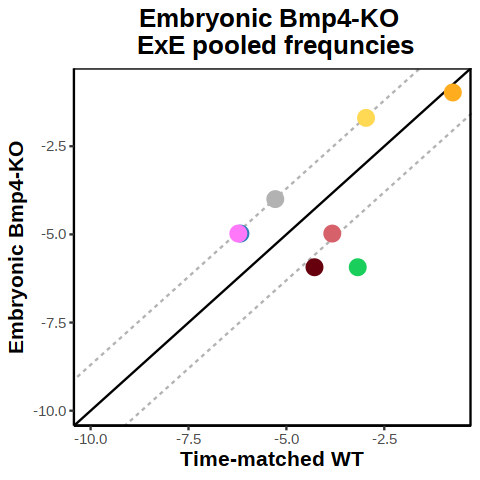

In [12]:
WT_pooled_EXE_ct_comp <- colSums(wt_exe_vs_ct)/sum(colSums(wt_exe_vs_ct))
TETRAPLOID_pooled_EXE_ct_comp <- colSums(tetraploid_exe_ko_ct)/sum(colSums(tetraploid_exe_ko_ct))
GERMLINE_pooled_EXE_ct_comp <- colSums(germline_exe_ko_ct)/sum(colSums(germline_exe_ko_ct))

EXE_Ct_comp_df <- data.frame(wt = log2(WT_pooled_EXE_ct_comp + 1e-3), 
                             tetraploid = log2(TETRAPLOID_pooled_EXE_ct_comp + 1e-3),
                             germline = log2(GERMLINE_pooled_EXE_ct_comp + 1e-3), 
                             col = names(WT_pooled_EXE_ct_comp))

plot_size(4,4)

min_val <- min(EXE_Ct_comp_df$wt,EXE_Ct_comp_df$tetraploid,EXE_Ct_comp_df$germline)
max_val <- max(EXE_Ct_comp_df$wt,EXE_Ct_comp_df$tetraploid,EXE_Ct_comp_df$germline)

ggplot(data = EXE_Ct_comp_df,aes(wt, tetraploid, col=col)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1.3, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1.3, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Embryonic Bmp4-KO \n ExE pooled frequncies") +
  scale_color_identity() +
  ylim(min_val,max_val) + 
  xlim(min_val,max_val) +
  ylab("Embryonic Bmp4-KO") +
  xlab("Time-matched WT") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 12),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

## EDF 10e

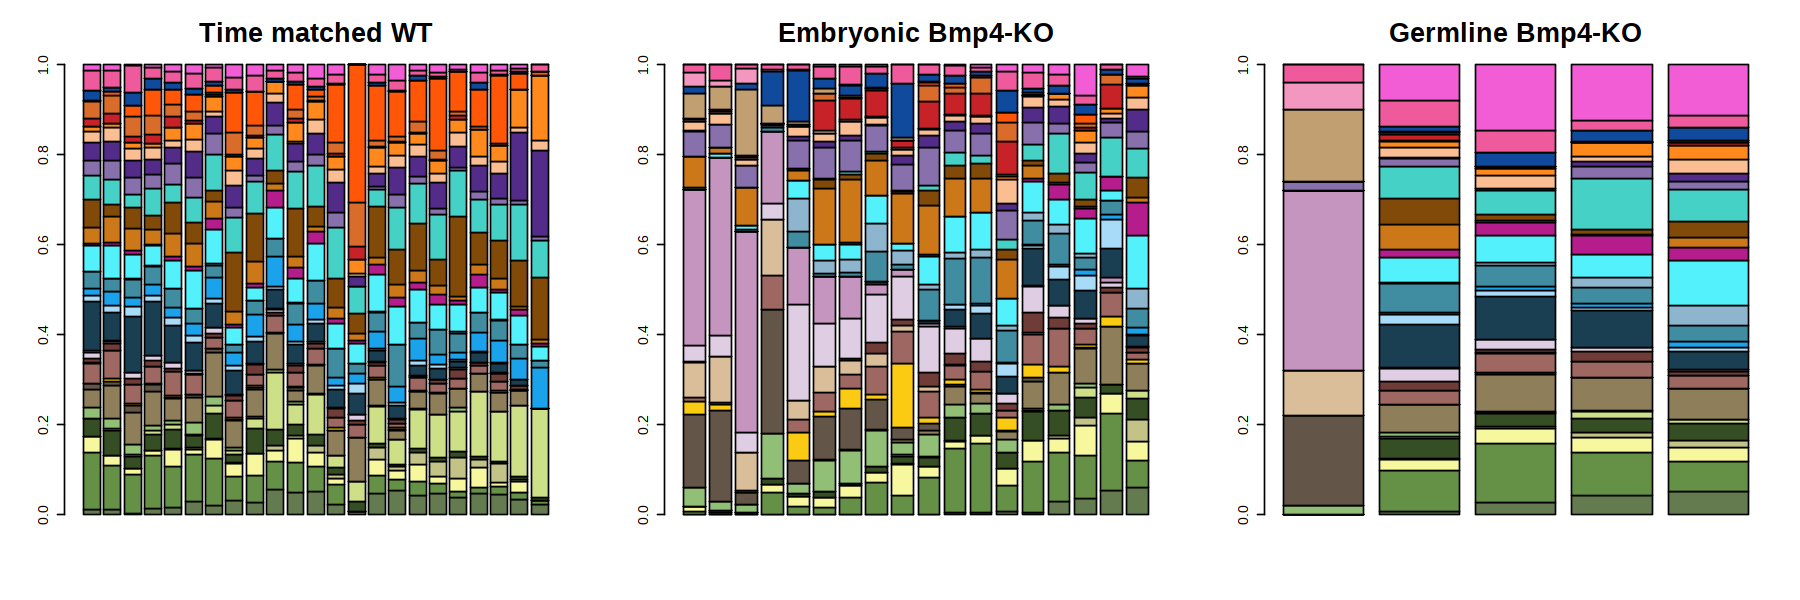

In [13]:
plot_size(15,5)
par(mfrow = c(1,3))

included_colors = mc_embexe@color_key$color[c(1:38)]

wt_emb_vs_ct = table(mat_all@cell_metadata[wt_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[wt_cells]],levels = mc_embexe@color_key$color[1:38]))

wt_emb_vs_ctn = wt_emb_vs_ct/rowSums(wt_emb_vs_ct)

barplot(t(wt_emb_vs_ctn),col = included_colors, names.arg = rep(NA,nrow(wt_emb_vs_ctn)),main = "Time matched WT", cex.main = 2)

####################################################################################################################

tetraploid_ko_ct = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[tetraploid_ko_cells],levels = mc_embexe@color_key$color[1:38]))

tetraploid_ko_ctn = tetraploid_ko_ct/rowSums(tetraploid_ko_ct)
tetraploid_ko_ctn <- tetraploid_ko_ctn[names(tetraploid_time),]

barplot(t(tetraploid_ko_ctn),col = included_colors, names.arg = rep(NA,length(tetraploid_ko_embryos)),main = "Embryonic Bmp4-KO", cex.main = 2)

####################################################################################################################

germline_ko_ct = table( mat_all@cell_metadata[germline_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[germline_ko_cells],levels = mc_embexe@color_key$color[1:38]))
germline_ko_ctn = germline_ko_ct/rowSums(germline_ko_ct)
germline_ko_ctn <- germline_ko_ctn[names(germline_time),]

barplot(t(germline_ko_ctn),col = included_colors, names.arg = rep(NA,length(germline_ko_embryos)),main = "Germline Bmp4-KO", cex.main = 2)

## EDF 12a

In [274]:
time_df_tetra = cmp_time %>% filter(cmp_time$embryo %in% tetraploid_ko_embryos) %>% select(embryo,best_rank_query,developmental_time)
time_df_tetra = time_df_tetra[order(time_df_tetra$developmental_time),]
time_df_tetra = time_df_tetra[time_df_tetra$developmental_time > 7.9,]
matching_tetra_embs = unique(mat_embexe@cell_metadata[ mat_embexe@cell_metadata$transcriptional_rank %in% time_df_tetra$best_rank_query,"embryo"])

time_df_germline = cmp_time %>% filter(cmp_time$embryo %in% germline_ko_embryos) %>% select(embryo,best_rank_query,developmental_time)
time_df_germline = time_df_germline[order(time_df_germline$developmental_time),]
time_df_germline = time_df_germline[time_df_germline$developmental_time > 7.9,]
matching_germline_embs = unique(mat_embexe@cell_metadata[ mat_embexe@cell_metadata$transcriptional_rank %in% time_df_germline$best_rank_query,"embryo"])

In [275]:
wt_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% mc_embexe@color_key$color[c(1:38)]]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

In [276]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% mc_embexe@color_key$color[c(1:38)]]

ko_tetra_cells = rownames(mat_all@cell_metadata)[mat_all@cell_metadata$embryo %in% time_df_tetra$embryo]
ko_tetra_cells = intersect(ko_tetra_cells,all_included_cells)

# matching_tetra_cells = rownames(mat_all@cell_metadata)[mat_all@cell_metadata$embryo %in% matching_tetra_embs]
matching_tetra_cells = wt_cells
matching_tetra_cells = intersect(matching_tetra_cells, all_included_cells)

ko_germline_cells = rownames(mat_all@cell_metadata)[mat_all@cell_metadata$embryo %in% time_df_germline$embryo]
ko_germline_cells = intersect(ko_germline_cells,all_included_cells)

# matching_germline_cells = rownames(mat_all@cell_metadata)[mat_all@cell_metadata$embryo %in% matching_germline_embs]
matching_germline_cells = wt_cells
matching_germline_cells = intersect(matching_germline_cells, all_included_cells)

In [277]:
match_tetra_vs_ct = table(mat_all@cell_metadata[matching_tetra_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[matching_tetra_cells]],
                            levels = mc_embexe@color_key$color[1:38]))

pool_match_tetra_ct_comp = colSums(match_tetra_vs_ct)/sum(colSums(match_tetra_vs_ct))

In [278]:
tetra_vs_ct = table(md_all[ko_tetra_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[ko_tetra_cells],
                            levels = mc_embexe@color_key$color[1:38]))

pool_tetra_ct_comp = colSums(tetra_vs_ct)/sum(colSums(tetra_vs_ct))

In [279]:
match_germline_vs_ct = table(mat_all@cell_metadata[matching_germline_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[matching_germline_cells]],
                            levels = mc_embexe@color_key$color[1:38]))

pool_match_germline_ct_comp = colSums(match_germline_vs_ct)/sum(colSums(match_germline_vs_ct))

In [280]:
germline_vs_ct = table(md_all[ko_germline_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[ko_germline_cells],
                            levels = mc_embexe@color_key$color[1:38]))

pool_germline_ct_comp = colSums(germline_vs_ct)/sum(colSums(germline_vs_ct))

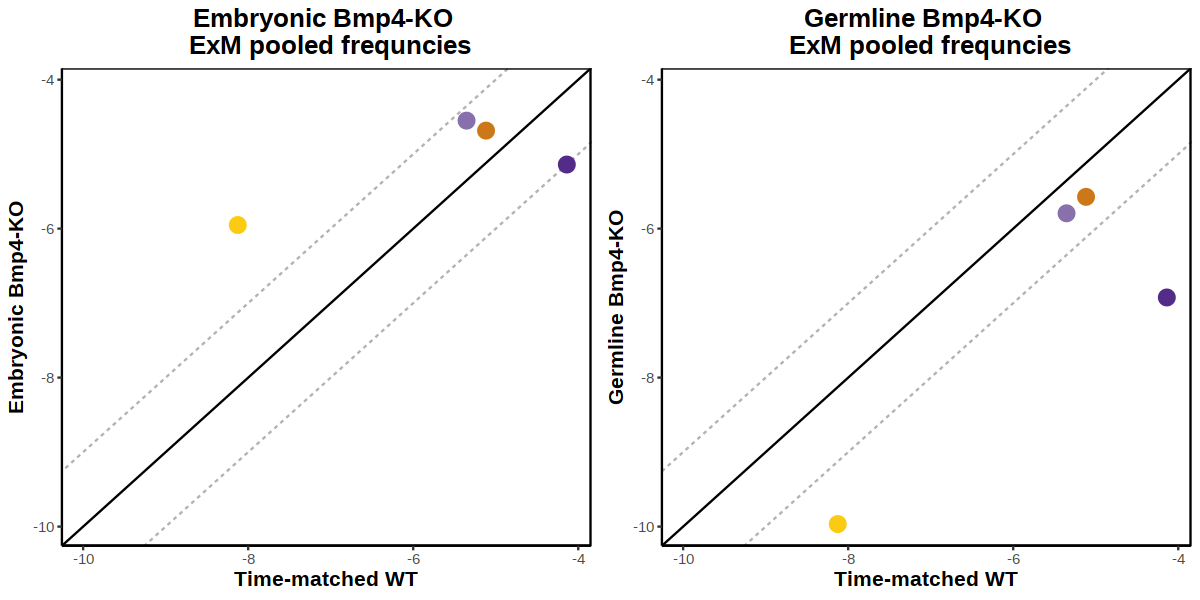

In [299]:
reg = 1e-3

pool_df = data.frame(tetra_ko = log2(pool_tetra_ct_comp + reg), 
                     tetra_match = log2(pool_match_tetra_ct_comp + reg),
                    germline_ko = log2(pool_germline_ct_comp + reg), 
                     germline_match = log2(pool_match_germline_ct_comp + reg),
                    col = names(pool_match_germline_ct_comp),
                    ct = col_to_ct[names(pool_match_germline_ct_comp)])

cts = c("ExE mesoderm","PGC","Amnion/Chorion progenitor","Allantois")
# cts = c("ExE mesoderm","PGC","Amnion/Chorion","Allantois")
pool_df_f = pool_df %>% filter(ct %in% cts)

plot_size(10,5)

min_val <- min(pool_df_f$tetra_ko,pool_df_f$tetra_match,pool_df_f$germline_ko,pool_df_f$germline_match)
max_val <- max(pool_df_f$tetra_ko,pool_df_f$tetra_match,pool_df_f$germline_ko,pool_df_f$germline_match)

p1 = ggplot(data = pool_df_f,aes(tetra_match, tetra_ko, col=col)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Embryonic Bmp4-KO \n ExM pooled frequncies") +
  scale_color_identity() +
  ylim(min_val,max_val) + 
  xlim(min_val,max_val) +
  ylab("Embryonic Bmp4-KO") +
  xlab("Time-matched WT") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 12),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p2 = ggplot(data = pool_df_f,aes(germline_match, germline_ko, col=col)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Germline Bmp4-KO \n ExM pooled frequncies") +
  scale_color_identity() +
  ylim(min_val,max_val) + 
  xlim(min_val,max_val) +
  ylab("Germline Bmp4-KO") +
  xlab("Time-matched WT") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 12),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

gridExtra::grid.arrange(p1,p2,nrow = 1)

In [282]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, c(grep("Ifitm", batch_genes, v = T)))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)

genes_f <- rownames(mat_all@mat)[! rownames(mat_all@mat) %in% bad_genes]

egc_all = t(t(mat_all@mat[genes_f,names(mc_all@mc)])/colSums(mat_all@mat[genes_f,names(mc_all@mc)]))

In [283]:
germline_amn_cells = names(cmp_annot$query_cls_col[ko_germline_cells] == "#cc7818")
germline_amn_cells = intersect(germline_amn_cells, colnames(egc_all))

tetra_amn_cells = names(cmp_annot$query_cls_col[ko_tetra_cells] == "#cc7818")
tetra_amn_cells = intersect(tetra_amn_cells, colnames(egc_all))

colors_match_germline = mc_all@colors[mc_all@mc[matching_germline_cells]] 
names(colors_match_germline) = matching_germline_cells
germline_match_amn_cells = names(colors_match_germline[colors_match_germline == "#cc7818"])
germline_match_amn_cells = intersect(germline_match_amn_cells, colnames(egc_all))

colors_match_tetra = mc_all@colors[mc_all@mc[matching_tetra_cells]] 
names(colors_match_tetra) = matching_tetra_cells
tetra_match_amn_cells = names(colors_match_tetra[colors_match_tetra == "#cc7818"])
tetra_match_amn_cells = intersect(tetra_match_amn_cells, colnames(egc_all))

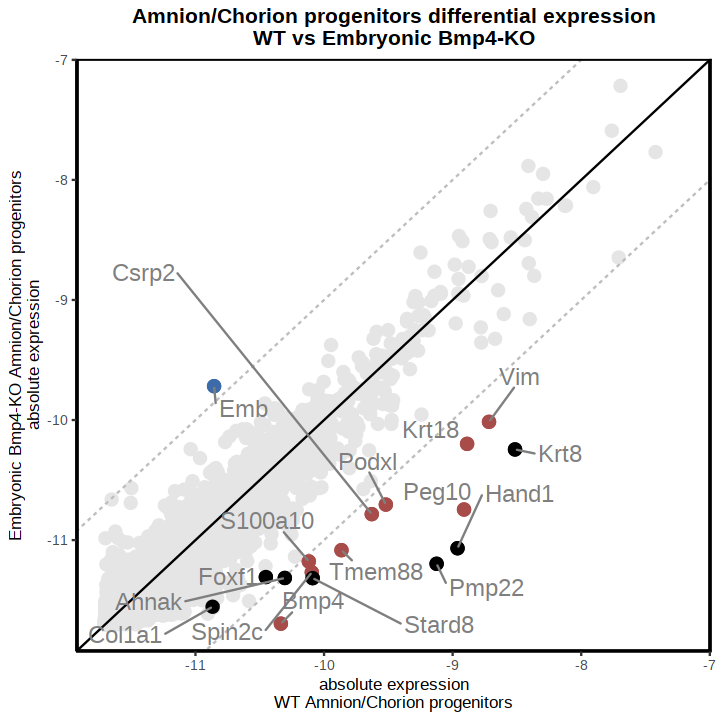

In [284]:
reg = 3e-4
fold = 2

dge1 <- matrix(log2(rowMeans(egc_all[,tetra_amn_cells]) + reg), dimnames = list(rownames(egc_all)))
dge2 <- matrix(log2(rowMeans(egc_all[,tetra_match_amn_cells]) + reg), dimnames = list(rownames(egc_all)))
temp <- cbind(dge1[,1],dge2[,1])

colnames(temp) <- c("gexp.query", "gexp.ref")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.query - temp$gexp.ref

up <- rownames(temp)[temp$diff > log2(fold)]
dn <- rownames(temp)[temp$diff < -log2(fold)]

mark <- c("Acta2","Krt8", "Mest", "Hand1", "Ahnak","Dlk1","Stard8","Pmp22","Col1a1", "Foxf1")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))
# rnms <- subset(rnms , rnms %in% c(up,dn))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

ylims <- c(log2(reg),max(c(temp$gexp.query,temp$gexp.ref)))
title.nm <- "Amnion/Chorion progenitors differential expression\nWT vs Embryonic Bmp4-KO"

pa <- ggplot(data = temp,aes(gexp.ref,gexp.query,col=log)) +
  geom_point(size = 3) +
geom_abline(slope = 1) +
geom_abline(slope = 1, intercept = -log2(fold),linetype="dashed",col="grey") +
geom_abline(slope = 1, intercept = log2(fold),linetype="dashed",col="grey") +
  ggtitle(title.nm) +
    xlim(ylims) + 
    ylim(ylims) + 
    xlab("absolute expression\nWT Amnion/Chorion progenitors") +
  ylab("Embryonic Bmp4-KO Amnion/Chorion progenitors\nabsolute expression") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

  scale_color_manual(values = c("dn"="#A74C48", 
                                "up"="#3D6BA9",
                                "mark" = "black",
                                "n"="#E5E5E5"))

p3 <- pa  +  geom_point(data=subset(temp, rownames(temp) %in% rnms),
                        aes(gexp.ref,gexp.query), size = 3) +

geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            max.overlaps = 50,
                            aes(gexp.ref,gexp.query,
                                col = "black",
                                label=intersect(rownames(temp),rnms)), size = 5, force = 80) +

theme(legend.position = "none", text = element_text(size = 10),
                panel.border = element_rect(fill=NA, size = 1))

plot_size(6,6)
print(p3)

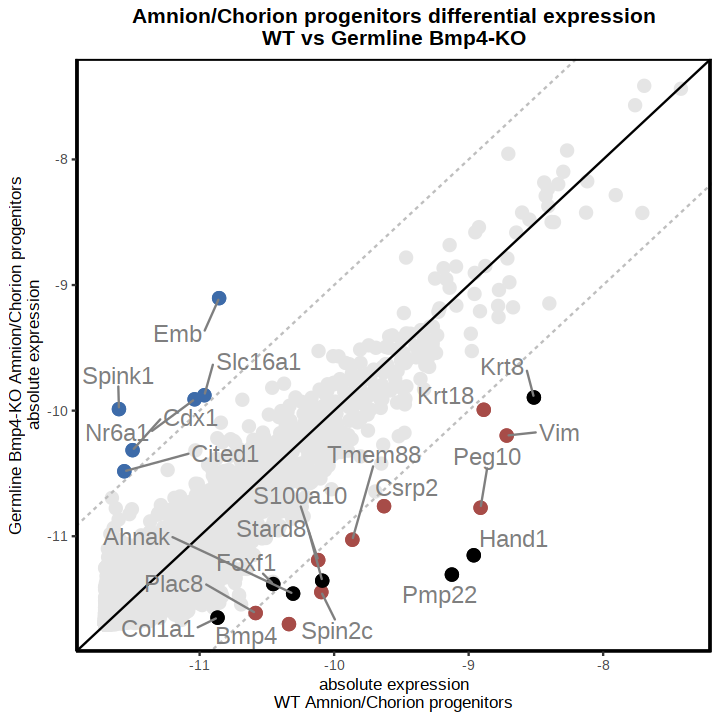

In [285]:
reg = 3e-4
fold = 2

dge1 <- matrix(log2(rowMeans(egc_all[,germline_amn_cells]) + reg), dimnames = list(rownames(egc_all)))
dge2 <- matrix(log2(rowMeans(egc_all[,germline_match_amn_cells]) + reg), dimnames = list(rownames(egc_all)))
temp <- cbind(dge1[,1],dge2[,1])

colnames(temp) <- c("gexp.query", "gexp.ref")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.query - temp$gexp.ref

up <- rownames(temp)[temp$diff > log2(fold)]
dn <- rownames(temp)[temp$diff < -log2(fold)]

mark <- c("Acta2","Krt8", "Mest", "Hand1", "Ahnak","Dlk1","Stard8","Pmp22","Col1a1", "Foxf1")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))
# rnms <- subset(rnms , rnms %in% c(up,dn))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

ylims <- c(log2(reg),max(c(temp$gexp.query,temp$gexp.ref)))
title.nm <- "Amnion/Chorion progenitors differential expression\nWT vs Germline Bmp4-KO"

pa <- ggplot(data = temp,aes(gexp.ref,gexp.query,col=log)) +
  geom_point(size = 3) +
geom_abline(slope = 1) +
geom_abline(slope = 1, intercept = -log2(fold),linetype="dashed",col="grey") +
geom_abline(slope = 1, intercept = log2(fold),linetype="dashed",col="grey") +
  ggtitle(title.nm) +
    xlim(ylims) + 
    ylim(ylims) + 
    xlab("absolute expression\nWT Amnion/Chorion progenitors") +
  ylab("Germline Bmp4-KO Amnion/Chorion progenitors\nabsolute expression") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

  scale_color_manual(values = c("dn"="#A74C48", 
                                "up"="#3D6BA9",
                                "mark" = "black",
                                "n"="#E5E5E5"))

p4 <- pa  +  geom_point(data=subset(temp, rownames(temp) %in% rnms),
                        aes(gexp.ref,gexp.query), size = 3) +

geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            max.overlaps = 50,
                            aes(gexp.ref,gexp.query,
                                col = "black",
                                label=intersect(rownames(temp),rnms)), size = 5, force = 80) +

theme(legend.position = "none", text = element_text(size = 10),
                panel.border = element_rect(fill=NA, size = 1))

plot_size(6,6)
print(p4)

### EDF 12b - see Figure_5_A_E notebook

## EDF 12c

In [14]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, grep("Ifitm", batch_genes, v = T))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

#bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)


In [15]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% included_colors]

wt_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

tetraploid_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_ko_embryos]
tetraploid_ko_cells <- intersect(tetraploid_ko_cells, all_included_cells)

tetraploid_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_control_embryos]
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, all_included_cells)

In [16]:
egc_list_tetraploid_embryos = tapply( tetraploid_ko_cells,mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                                function(query_cells) {
    egc_q = t(tgs_matrix_tapply(x = mat_all@mat[,query_cells],
                         index = cmp_annot$query_cls_col[query_cells],
                         fun = sum))
                                    
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(egc_q)
}) 

In [17]:
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, names(cmp_annot$query_cls_col))

egc_list_tetraploid_ctrl_embryos = tapply( tetraploid_ctrl_cells,mat_all@cell_metadata[ tetraploid_ctrl_cells,"embryo"],
                                function(query_cells) {
    egc_q = t(tgs_matrix_tapply(x = mat_all@mat[,query_cells],
                         index = cmp_annot$query_cls_col[query_cells],
                         fun = sum))
                                    
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(egc_q)
}) 

In [18]:
emb_ko_ct_all = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[tetraploid_ko_cells],
                            levels = mc_embexe@color_key$color[c(1:41,43:50)]))

tmp <- colSums(emb_ko_ct_all)
included_colors <- names(tmp[tmp > 10])

In [19]:
time_query_embryos = read.table("data/embexe_bmp4/time_match/time_match_summary.txt",sep = '\t',h = T)
time_query_embryos = time_query_embryos  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))
rownames(time_query_embryos) = time_query_embryos$embryo

# included_colors <- mc_embexe@color_key$color[1:38]
wt_cells = names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells_all = wt_cells

Joining, by = "best_rank_query"


In [20]:
roll_window = 6

cmp_matched_tetraploid_egc = lapply( tetraploid_ko_embryos,function(query_embryo) {

    matched_wt_rank = time_query_embryos[ query_embryo,'best_rank_query']
    
    matched_wt_cells = intersect(wt_cells,names(mc_all@mc))
    matched_wt_cells = matched_wt_cells [mat_all@cell_metadata[matched_wt_cells ,"transcriptional_rank"] %in% c((matched_wt_rank - roll_window):(matched_wt_rank + roll_window))]
    
    n_cells_per_cell_type = table( factor(x = col_to_ct[ mc_all@colors[ mc_all@mc[matched_wt_cells]]],levels = col_to_ct))
    
    matched_egc_wt = t(tgs_matrix_tapply(x = mat_all@mat[,matched_wt_cells],
                         index = mc_all@colors[mc_all@mc[matched_wt_cells]],
                         fun = sum))
    
    matched_egc_wt = t(t(matched_egc_wt)/colSums(matched_egc_wt))
    
    return(list("matched_egc_wt" = matched_egc_wt,
                "matched_wt_cells" = matched_wt_cells,
                "n_cells_per_cell_type" = n_cells_per_cell_type))
})

names(cmp_matched_tetraploid_egc) = tetraploid_ko_embryos

In [21]:
cmp_matched_control_egc = lapply( tetraploid_control_embryos,function(query_embryo) {

    matched_wt_rank = time_query_embryos[ query_embryo,'best_rank_query']
    
    matched_wt_cells = intersect(wt_cells,names(mc_all@mc))
    matched_wt_cells = matched_wt_cells [mat_all@cell_metadata[matched_wt_cells ,"transcriptional_rank"] %in% c((matched_wt_rank - roll_window):(matched_wt_rank + roll_window))]
    
    n_cells_per_cell_type = table( factor(x = col_to_ct[ mc_all@colors[ mc_all@mc[matched_wt_cells]]],levels = col_to_ct))
    
    matched_egc_wt = t(tgs_matrix_tapply(x = mat_all@mat[,matched_wt_cells],
                         index = mc_all@colors[mc_all@mc[matched_wt_cells]],
                         fun = sum))
    
    matched_egc_wt = t(t(matched_egc_wt)/colSums(matched_egc_wt))
    
    return(list("matched_egc_wt" = matched_egc_wt,
                "matched_wt_cells" = matched_wt_cells,
                "n_cells_per_cell_type" = n_cells_per_cell_type))
})

names(cmp_matched_control_egc) = tetraploid_control_embryos

In [22]:
tetraploid_control_ct = table( mat_all@cell_metadata[ tetraploid_ctrl_cells,"embryo"],
                       factor(x = col_to_ct[ cmp_annot$query_cls_col[tetraploid_ctrl_cells]], 
                              levels = col_to_ct))

tetraploid_ko_ct = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                       factor(x =col_to_ct[ cmp_annot$query_cls_col[tetraploid_ko_cells]], 
                              levels = col_to_ct))

In [23]:
min_number_of_query_cells_per_cell_type = 10
reg = 5e-5

vector_of_selected_cell_types = c("Early nascent mesoderm","ExE mesoderm","Allantois")
#vector_of_selected_cell_types = c("Early nascent mesoderm","ExE mesoderm")

lfc_selected_tetraploid_list = list()
egc_query_selected_tetraploid_list = list()
egc_matched_wt_selected_tetraploid_list = list()

vector_of_tetraploid_ko_embryos = c()

for (selected_cell_type in vector_of_selected_cell_types) {
    selected_query_embryos = rownames(tetraploid_ko_ct)[tetraploid_ko_ct[,selected_cell_type] >= min_number_of_query_cells_per_cell_type]

    selected_cell_type <- array(ct_to_col[selected_cell_type])
    
    selected_query_embryos = selected_query_embryos[order( time_query_embryos[selected_query_embryos,"best_rank_query"])]
    vector_of_tetraploid_ko_embryos = c(vector_of_tetraploid_ko_embryos,selected_query_embryos)

    selected_egcs = lapply(cmp_matched_tetraploid_egc[selected_query_embryos],function(cmp) {
        return(cmp$matched_egc_wt[,selected_cell_type])
    })

    egc_wt_matched_selected = do.call(what = cbind,args = selected_egcs)
    egc_query_selected = lapply(egc_list_tetraploid_embryos[selected_query_embryos],function(mat_egc) {
        return(mat_egc[,selected_cell_type])
    })

    egc_query_selected = do.call(cbind,egc_query_selected)
    
    
    n_wt_cells_selected = do.call(c,lapply(cmp_matched_tetraploid_egc[selected_query_embryos],function(cmp) { 
        return(cmp$n_cells_per_cell_type[selected_cell_type])
    }))
    
    lfc_selected = log2(egc_query_selected + reg) - log2(egc_wt_matched_selected + reg)
    
    lfc_selected_tetraploid_list[[selected_cell_type]] = lfc_selected
    egc_query_selected_tetraploid_list[[selected_cell_type]] = egc_query_selected
    egc_matched_wt_selected_tetraploid_list[[selected_cell_type]] = egc_wt_matched_selected
    
}

In [24]:
lfc_control_selected_list = list()
egc_control_selected_list = list()
egc_matched_wt_control_selected_list = list()
vector_of_control_embryos = c()

for (selected_cell_type in vector_of_selected_cell_types) {
    selected_query_embryos = rownames(tetraploid_control_ct)[tetraploid_control_ct[,selected_cell_type] >= min_number_of_query_cells_per_cell_type]

    selected_cell_type <- array(ct_to_col[selected_cell_type])
    
    selected_query_embryos = selected_query_embryos[order( time_query_embryos[selected_query_embryos,"best_rank_query"])]
    vector_of_control_embryos = c(vector_of_control_embryos,selected_query_embryos)

    selected_egcs = lapply(cmp_matched_control_egc[selected_query_embryos],function(cmp) {
        return(cmp$matched_egc_wt[,selected_cell_type])
    })

    egc_wt_matched_selected = do.call(what = cbind,args = selected_egcs)
    egc_query_selected = lapply(egc_list_tetraploid_ctrl_embryos[selected_query_embryos],function(mat_egc) {
        return(mat_egc[,selected_cell_type])
    })

    egc_query_selected = do.call(cbind,egc_query_selected)
    
    
    n_wt_cells_selected = do.call(c,lapply(cmp_matched_control_egc[selected_query_embryos],function(cmp) { 
        return(cmp$n_cells_per_cell_type[selected_cell_type])
    }))
    
    lfc_selected = log2(egc_query_selected + reg) - log2(egc_wt_matched_selected + reg)
    
    lfc_control_selected_list[[selected_cell_type]] = lfc_selected
    egc_control_selected_list[[selected_cell_type]] = egc_query_selected
    egc_matched_wt_control_selected_list[[selected_cell_type]] = egc_wt_matched_selected
    
}

In [25]:
lfc_tetraploid_ko = do.call(cbind,lfc_selected_tetraploid_list)
lfc_tetraploid_control = do.call(cbind,lfc_control_selected_list)

egc_query_tetraploid_ko_all = do.call(cbind,egc_query_selected_tetraploid_list)
egc_query_tetraploid_control_all = do.call(cbind,egc_control_selected_list)

egc_ref_tetraploid_ko_all = do.call(cbind,egc_matched_wt_selected_tetraploid_list)
egc_ref_tetraploid_control_all = do.call(cbind,egc_matched_wt_control_selected_list)

lfc_all_ko = lfc_tetraploid_ko
colnames(lfc_all_ko) = c(1:ncol(lfc_all_ko))

lfc_all = cbind(lfc_tetraploid_ko,lfc_tetraploid_control)
colnames(lfc_all) = c(1:ncol(lfc_all))

egc_query_all = cbind(egc_query_tetraploid_ko_all,egc_query_tetraploid_control_all)

egc_ref_all = cbind(egc_ref_tetraploid_ko_all,egc_ref_tetraploid_control_all)

In [26]:

annotation_vector_all <- c(rep(names(do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
                               times = do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
                           
                           rep(names(do.call(c,lapply(lfc_control_selected_list,ncol))),
                               times = do.call(c,lapply(lfc_control_selected_list,ncol))))

genotype_vector_all <- c(rep("tKO",ncol(lfc_tetraploid_ko)),
                         rep("Control",ncol(lfc_tetraploid_control)))

embryo_vector_all <- c(vector_of_tetraploid_ko_embryos,vector_of_control_embryos)


df_ann <- data.frame("cell_type" = array(col_to_ct[annotation_vector_all]), 
                     "genotype" = genotype_vector_all)

rownames(df_ann) = c(1:nrow(df_ann))

annotation_colors = list("cell_type" = ct_to_col,
                        "genotype" = c("tKO" = "#737373",
                                     "Control" = "#C9C9C9",
                                     "gKO" = '#000000',
                                      "gControl" = 'white'))

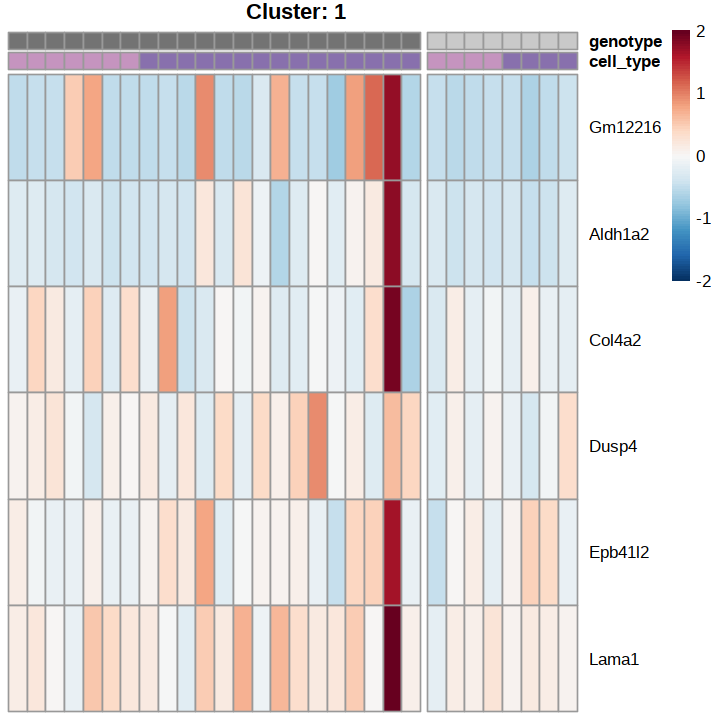

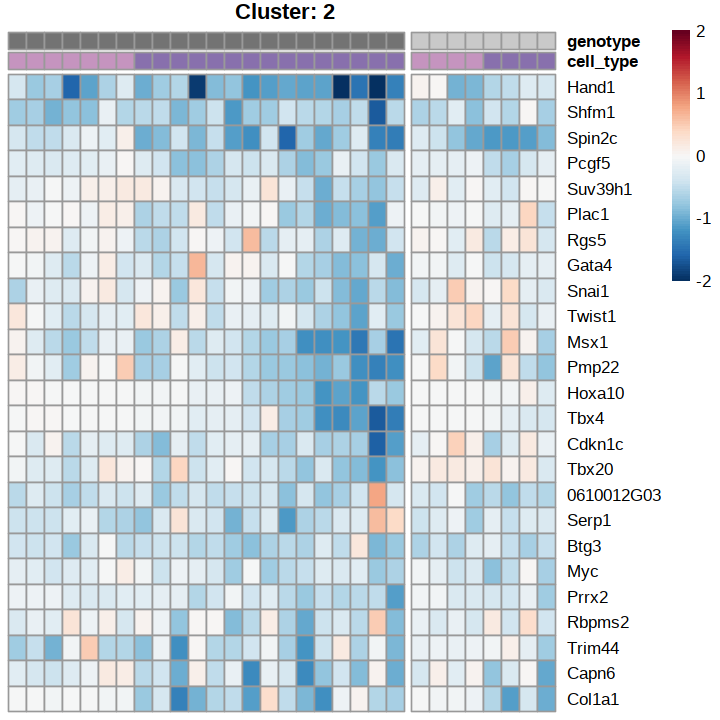

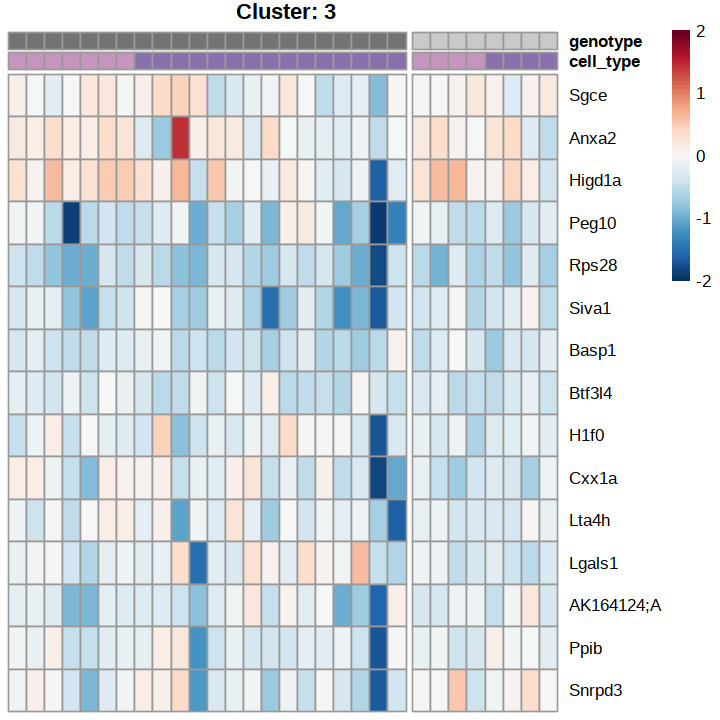

In [27]:
fold_change_threshold <- log2(3)
#f_var = apply(lfc_all_ko,1,min) < -fold_change_threshold
f_var = apply(abs(lfc_all_ko),1,max) >= fold_change_threshold

f_min = apply(cbind(egc_query_all,egc_ref_all),1,max) > 1e-4

genes_selected = rownames(lfc_all)[f_var & f_min]
genes_selected <- setdiff(genes_selected, "Bmp4")
genes_selected = setdiff(genes_selected,bad_genes)

options(repr.plot.width=6, repr.plot.height=6)
shades_rdbu <- colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100)
breaks = seq(-2,2,length.out = 101)

n_cluster = 3
kmeans_genes = tglkmeans::TGL_kmeans(df = lfc_all[genes_selected,],k = n_cluster,id_column = F,seed = 123)
names(kmeans_genes$cluster) = genes_selected

for (cl in 1:n_cluster) {
    
    f = kmeans_genes$cluster == cl     
    lfc_f = lfc_all[genes_selected[f],]
    
    rownames(lfc_f) = substr(x = rownames(lfc_f),start = 1,stop = 10)
    f_ct = df_ann$cell_type == "Allantois"
    df_ann_f = df_ann[!f_ct,]
    pheatmap::pheatmap(mat = lfc_f[,!f_ct],show_colnames = F,show_rownames = T,
                       annotation_legend = F,
                       treeheight_row = 0,
                       gaps_col = c(max(which(df_ann_f$genotype == "tKO")), max(which(df_ann_f$genotype == "Control"))),
                       color = rev(shades_rdbu),
                       breaks = breaks,
                       cluster_cols = F,
                       cluster_rows = T,
                       annotation_col = df_ann_f,
                       annotation_colors = annotation_colors,
                       main = sprintf("Cluster: %s",cl))
}

## EDF 12f - see notebook Figure 5H-L

## EDF 13b - see notebook Figure 5H-L